In [1]:
import os
import sys
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings("ignore")
PACKAGE_ROOT = os.path.dirname(os.path.abspath(""))
# print(PACKAGE_ROOT)
sys.path.insert(0, PACKAGE_ROOT)

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import \
    Embedding, LSTM, Bidirectional, TimeDistributed, Dense, Dropout
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
plt.style.use("ggplot")

from preprocessing.lstm_softmax_preprocessor import LSTMSoftmaxPreprocessor
from utils.utils import get_connl_data
from commons import constants as C
from data.ingestor import DataSaver

In [2]:
train_df = get_connl_data("train")
valid_df = get_connl_data("valid")
test_df = get_connl_data("test")

obj = LSTMSoftmaxPreprocessor()
train_sentences = obj.get_sentences(train_df)
valid_sentences = obj.get_sentences(valid_df)
test_sentences = obj.get_sentences(test_df)

In [3]:
words = obj.get_words(train_df)
n_words = len(words)
print(f"Number of words: {n_words}")
tags = obj.get_tags(train_df)
# print(tags)
n_tags = len(tags)
print(f"Number of tags: {n_tags}")
max_length = obj.get_max_length(train_sentences)
print(f"Maximum length of sentence: {max_length}")

Number of words: 29574
Number of tags: 67
Maximum length of sentence: 52


In [4]:
word2idx, idx2word, tag2idx, idx2tag = obj.get_indices(words, tags)
X_train, y_train = obj.preprocess(
    train_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)

X_valid, y_valid = obj.preprocess(
    valid_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)

X_test, y_test = obj.preprocess(
    test_sentences, word2idx, tag2idx, max_length, n_tags, n_words
)

In [9]:
input = Input(shape=(max_length,))
model = Embedding(input_dim=n_words, output_dim=50, input_length=max_length)(input)  # 50-dim embedding
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1))(model)  # biderctional biLSTM
out = TimeDistributed(Dense(n_tags, activation="softmax"))(model)  # softmax output layer
model = Model(input, out)
# compile
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
# show summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 52)]              0         
                                                                 
 embedding (Embedding)       (None, 52, 50)            1478700   
                                                                 
 dropout (Dropout)           (None, 52, 50)            0         
                                                                 
 bidirectional (Bidirectiona  (None, 52, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 52, 67)           13467     
 ibuted)                                                         
                                                                 
Total params: 1,612,967
Trainable params: 1,612,967
Non-train

In [8]:
model_type = "lstmsoftmax"
now = datetime.utcnow() + timedelta(hours=5, minutes=30)
FOLDER_NAME = f"{model_type}-model-"+now.strftime("%d-%m-%Y-%H-%M-%S")
FOLDER_PATH = os.path.join(C.MODELS_OUTPUT_DIR, FOLDER_NAME)
print(FOLDER_PATH)
if not os.path.exists(FOLDER_PATH):
    os.makedirs(FOLDER_PATH)
checkpoint_filepath = os.path.join(FOLDER_PATH, "checkpoint")
# FILE_PATH = os.path.join(C.MODELS_OUTPUT_DIR, FILE_NAME)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

C:\Users\sharm\Documents\workspace\gitworks\ner-bilstm-crf\outputs\model_artifacts\lstmsoftmax-model-26-03-2023-02-15-41


In [7]:
history = model.fit(
    X_train, np.array(y_train), 
    batch_size=128, 
    epochs=50, 
    validation_data=(X_valid, np.array(y_valid)), 
    verbose=1, 
    callbacks=[model_checkpoint_callback]
)

Epoch 1/50
113/113 [==============================] - 21s 166ms/step - loss: 0.5768 - accuracy: 0.9315 - val_loss: 0.3764 - val_accuracy: 0.9404
Epoch 2/50
113/113 [==============================] - 18s 158ms/step - loss: 0.3714 - accuracy: 0.9398 - val_loss: 0.3646 - val_accuracy: 0.9404
Epoch 3/50
113/113 [==============================] - 23s 201ms/step - loss: 0.3536 - accuracy: 0.9398 - val_loss: 0.3414 - val_accuracy: 0.9404
Epoch 4/50
113/113 [==============================] - 27s 243ms/step - loss: 0.3361 - accuracy: 0.9398 - val_loss: 0.3273 - val_accuracy: 0.9404
Epoch 5/50
113/113 [==============================] - 27s 242ms/step - loss: 0.3216 - accuracy: 0.9398 - val_loss: 0.3152 - val_accuracy: 0.9404
Epoch 6/50
113/113 [==============================] - 27s 240ms/step - loss: 0.3101 - accuracy: 0.9400 - val_loss: 0.3136 - val_accuracy: 0.9406
Epoch 7/50
113/113 [==============================] - 27s 237ms/step - loss: 0.3004 - accuracy: 0.9404 - val_loss: 0.3019 - val_ac

In [11]:
filepath = r"C:\Users\sharm\Documents\workspace\gitworks\ner-bilstm-crf\outputs\model_artifacts\lstmcrf-model-26-03-2023-01-12-32\checkpoint"
model.load_weights(filepath)

Loss


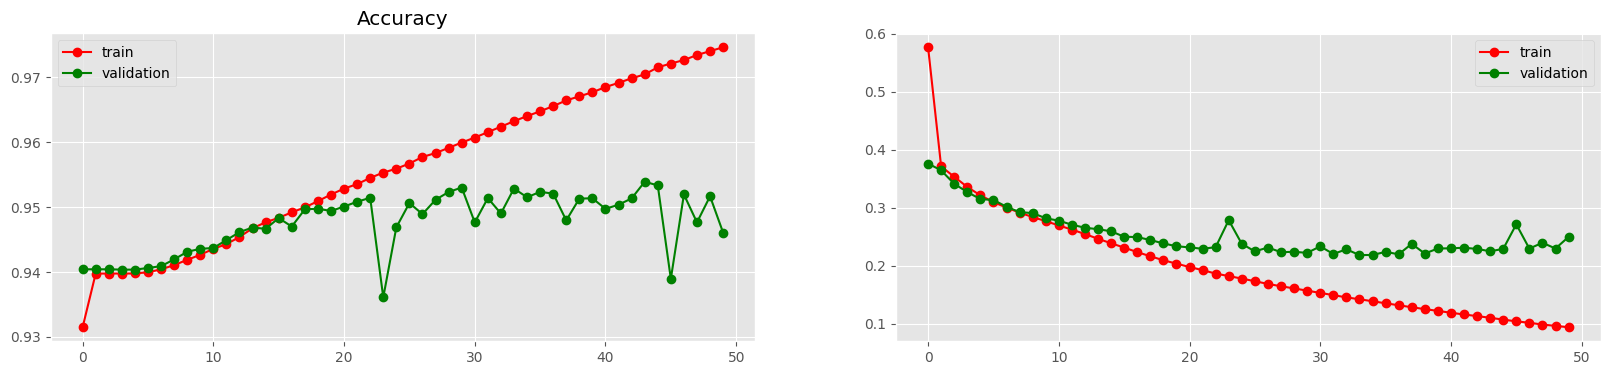

In [8]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(20,4))
plt.subplot(1, 2, 1)
plt.title("Accuracy")
plt.plot(hist["accuracy"], label="train", marker="o", c="red")
plt.plot(hist["val_accuracy"], label="validation", marker="o", c="green")
plt.legend()
# plt.show()
plt.subplot(1, 2, 2)
print("Loss")
plt.plot(hist["loss"], label="train", marker="o", c="red")
plt.plot(hist["val_loss"], label="validation", marker="o", c="green")
plt.legend()
plt.show()

In [9]:
ds = DataSaver()
train_report_df = obj.inference(model, X_train, idx2tag, train_sentences)
ds.save_report(train_report_df, "lstmsoftmax", "train")

valid_report_df = obj.inference(model, X_valid, idx2tag, valid_sentences)
ds.save_report(valid_report_df, "lstmsoftmax", "valid")

test_report_df = obj.inference(model, X_test, idx2tag, test_sentences)
ds.save_report(test_report_df, "lstmsoftmax", "test")

6611/6611 [==============================] - 197s 30ms/step


## METRICS

In [7]:
import os
import plotly.express as px
from datetime import datetime, timedelta
import pandas as pd

In [8]:
METRICS_DIR = r"C:\Users\sharm\Documents\workspace\gitworks\ner-bilstm-crf\outputs\metrics"
model_names = ["tagger", "crf", "lstmsoftmax", "lstmcrf"]
split_types = ["train", "valid", "test"]

file_names = os.listdir(METRICS_DIR)

latest_reports = []
for mname in model_names:
    reports = [fname for fname in file_names if fname.startswith(mname)]
    if len(reports) == 0:
        continue
    for st in split_types:
        print(mname, st)
        fnames = [report for report in reports if st in report]
        if len(fnames) == 0:
            continue
        fnames = [(fname, 
                datetime.strptime("-".join(fname.split(".")[0].split("-")[4:]), "%d-%m-%Y-%H-%M-%S"))
                for fname in fnames]
        fnames = sorted(fnames, reverse=True, key=lambda s: s[1])
        latest_reports.append(fnames[0])

latest_reports = [lr[0] for lr in latest_reports]
latest_reports

tagger train
tagger valid
tagger test
crf train
crf valid
crf test
lstmsoftmax train
lstmsoftmax valid
lstmsoftmax test
lstmcrf train
lstmcrf valid
lstmcrf test


['tagger-model-train-data-25-03-2023-17-29-25.csv',
 'tagger-model-valid-data-25-03-2023-17-29-25.csv',
 'tagger-model-test-data-25-03-2023-17-29-25.csv',
 'crf-model-train-data-25-03-2023-17-29-30.csv',
 'crf-model-valid-data-25-03-2023-17-29-30.csv',
 'crf-model-test-data-25-03-2023-17-30-16.csv',
 'lstmsoftmax-model-train-data-26-03-2023-01-03-50.csv',
 'lstmsoftmax-model-valid-data-26-03-2023-01-03-50.csv',
 'lstmsoftmax-model-test-data-26-03-2023-01-07-47.csv',
 'lstmcrf_ep50-model-train-data-26-03-2023-01-39-45.csv',
 'lstmcrf_ep50-model-valid-data-26-03-2023-01-39-46.csv',
 'lstmcrf_ep50-model-test-data-26-03-2023-01-45-04.csv']

In [2]:
all_reports = []
for fname in latest_reports:
    name_list = fname.split("-")
    model_name = name_list[0]
    split_type = name_list[2]

    report_df = pd.read_csv(os.path.join(METRICS_DIR, fname))
    report_df.columns = ["tag_type", "precision", "recall", "f1_score", "support"]
    report_df["model_name"] = model_name
    report_df["split_type"] = split_type
    # print(report_df.to_dict("records"))
    all_reports.extend(report_df.to_dict("records"))
    # break
all_reports_df = pd.DataFrame(all_reports)
all_reports_df.head()

NameError: name 'latest_reports' is not defined

In [1]:
# tmp_df = all_reports_df[all_reports_df["split_type"] == "train"]
tmp_df = all_reports_df[all_reports_df["model_name"] == "tagger"]
# tmp_df = all_reports_df
fig = px.line(tmp_df, x="tag_type", y="f1_score", color="model_name", markers="o")
fig.show()

NameError: name 'all_reports_df' is not defined

In [23]:
tmp_df = all_reports_df
fig = px.line(tmp_df, x="tag_type", y="f1_score", color="model_name", markers="o")
fig.show()

In [19]:
tmp_df = all_reports_df[all_reports_df["split_type"] == "valid"]
fig = px.line(tmp_df, x="tag_type", y="f1_score", color="model_name", markers="^")
fig.show()